In [1]:
# Given users review predit overall rating given by user
import json
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import random
import collections
import math


In [7]:
# read json data

# preprocess data
def preprocess_data(filepath="./dataset/Music_Review_train.json"):
    raw_data = pd.read_json(filepath,lines=True)
    X=raw_data['reviewText']
    Y=raw_data['overall']
    sw_nltk=set(stopwords.words('english'))
    
    output=[]
    for sentence in X:
        # tokenize sentence
        tokens=word_tokenize(sentence)
        # normalize
        tokens=[w.lower() for w in tokens]
        # remove punctuation
        table=str.maketrans('','',string.punctuation)
        stripped=[w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words=[word for word in stripped if word.isalpha()]
        # filter out stop words
        words=[w for w in words if not w in sw_nltk]
        # filter out stem words
        ps=PorterStemmer()
        words=[ps.stem(w) for w in words]
        output.append(np.asarray(words) )
    return np.asarray(output),Y
def vocab_assist(X_c):
    # use default dictionary
    dicta=collections.defaultdict(int)
    for i in range(len(X_c)):
        for word in X_c[i]:
            if word not in dicta:
                dicta[word]=1
            else:
                dicta[word]+=1
    return dicta


def get_vocabulary(X_c,Y):
    class_vocab=[]
    class_vocab.append(vocab_assist(X_c))
    for class_label in range(5):
        tempdict=vocab_assist(X_c[np.where(Y==class_label+1)])
        class_vocab.append(tempdict)
    return class_vocab

# Naive bayes from scratch
def naive_bayes(X,Y):
    # number of examples = m
    m=len(X)
    # class then vocabulary
    # psi_i=[[],[],[],[],[]]
    psi_i=[{},{},{},{},{}]
    psi_y=[]
    # get vocabulary
    vocab=get_vocabulary(X,Y)
    for class_label in range(5):
        denom=sum([len(row) for row in X[np.where(Y==class_label+1)]])+len(vocab[0])
        for word in vocab[0]:
            psi_i[class_label][word]=(vocab[class_label+1][word]+1)/denom            
        psi_y.append(len(X[np.where(Y==class_label+1)])/m)
    return psi_i,psi_y

def predict(x,psi_i,psi_y):
    class_prob=[]
    denom=0
    for class_label in range(5):
        numer=1
        for word in x:
            # start from here again
            numer+=math.log(psi_i[class_label][word])+math.log(psi_y[class_label])
        denom+=numer
        p_y_x=numer
        class_prob.append(p_y_x)
    # class_prob.append(denom)
    class_prob=np.asarray(class_prob)-denom
    return class_prob        
def get_predictions(X_c,psi_i,psi_y):
    Y=[]
    for x in X_c:
        class_prob=predict(x,psi_i,psi_y)
        Y.append(np.argmax(class_prob)+1)
    return Y

def test(temp_X,Y,psi_i,psi_y):
    total=0
    for x in range(len(temp_X)):
        if 1+np.argmax(predict(temp_X[x],psi_i,psi_y))==Y[x]:
            total+=1
    return total/len(temp_X)
def random_prediction(X_c,Y):
    # randomly predict class for each example
    class_label=[]
    for i in range(len(X_c)):
        class_label.append(random.randint(1,5))
    return np.count_nonzero(Y==class_label)/len(X_c)
def majority_prediction(X_c,Y):
    # majority vote
    Y_pred=np.argmax(np.bincount(Y))
    return np.count_nonzero(Y==Y_pred)/len(X_c)


In [3]:
# train
train_X,train_Y=preprocess_data("./dataset/Music_Review_train.json")
psi_i,psi_y=naive_bayes(train_X,train_Y)
print(predict(train_X[0],psi_i,psi_y))
print(test(train_X,train_Y,psi_i,psi_y))
print(random_prediction(train_X,train_Y))
print(majority_prediction(train_X,train_Y))

C:\Users\91930\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[21591.27252695 21808.58301955 22378.36404743 22939.10990261
 23286.43709212]
0.5187
0.20284
0.51864


In [4]:
test_X,test_Y=preprocess_data("./dataset/Music_Review_test.json")
print(test(test_X,test_Y,psi_i,psi_y))
print(random_prediction(test_X,test_Y))
print(majority_prediction(test_X,test_Y))


C:\Users\91930\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyError: 'agepop'

F1 Score
[7.89889415e-04 0.00000000e+00 0.00000000e+00 4.52147702e-04
 6.83059821e-01]
Confusion Matrix
[[    1     0     0     0  2528]
 [    0     0     0     0  2638]
 [    0     0     0     0  5634]
 [    1     0     0     3 13263]
 [    1     0     0     0 25931]]
Macro F1 Score
0.13686037170442333


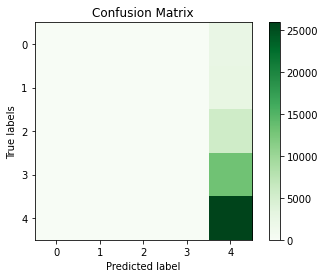

In [8]:
# plot confusion matrix for test data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
def draw_confusion(confatrix):
	plt.imshow(confatrix)
	plt.title("Confusion Matrix")
	plt.colorbar()
	plt.set_cmap("Greens")
	plt.ylabel("True labels")
	plt.xlabel("Predicted label")
	plt.show()
predictions=get_predictions(train_X,psi_i,psi_y)
confatrix = confusion_matrix(train_Y,predictions)
f1_matrix = f1_score(train_Y,predictions,average=None)
print("F1 Score")
print(f1_matrix)
print("Confusion Matrix")
print(confatrix)
macro_f1 = f1_score(train_Y,predictions,average='macro')
print("Macro F1 Score")
print(macro_f1)
draw_confusion(confatrix)


In [9]:
print(test_Y[0])

5


In [6]:
import collections
cc=[collections.defaultdict(int) for i in range(100)]
cc[0][0]+=1
cc[0][1]+=1
cc[0][2]+=1
cc[0][2]+=1
cc[0][2]+=1

print(max(zip(cc[0].values(),cc[0].keys()))[1])

2
